## to add
- ~~look at frequencies found around peak volume (more than just two, see what optimal number is)
- ~~remove points at the two ends of the spectrum, they are not going to be right at the peak
    - this will reduce the number of false peaks found, and we can get the two tallest peaks
    - then take the difference in frequency between the two tallest peaks (and maybe the height percentage)
    - this should add infromation that just the peak location will not provide
- top two frequencies from each specrtum
- check the power in each frequency-band
- if same birds keep getting mis-identified (due to similar frequencies) just classify them into a single group
- apply filter to groups
    -determine filter level based on whether the background frequency up to a certain band is there for the entire signal!!!!
- cast the signal into a different sample rate, see if it gets better/differnt results
- maybe use flatness locator from librosa


if same binning for the differnt transform types (i.e. the 'loudest point')
- extract the different features from each of the spectra at that bin location
- Q: to use all of the cepstral coefficients? or just the 'most important'?
    - how to know what the most important cepstralcoefficients are?
    

librosa produces 320 bins by defaults (this depends of sample rate?) (44100) -> (125)
48000 -> (136 bins)

- peak spacing in rms peaks
- get prominent frequency for torch mel spectrogram
- distance between volume peaks in mrel spec
- number of peaks in rms spcrum?

turn off ~~smart~~ *dumb* complete

In [33]:
#I want a manual transmission, not an automatic...
# Run this in Python once, it should take effect permanently (change to False to None to revert)
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Notebook': {'Toolbar': True, 'Header': True},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

all about birds suggests that most cals are betweem 1000 and 8000 Hz
- filter out calls below 400 Hz to start, and see what the effect is.
- in mel freq filter below 500 Hz
achieve the filtering by setting all rows lower than a certain value to zero in the stft array

In [12]:
import os
cwd = os.getcwd()
path =  os.path.join( cwd, '../examples/cutclips_old' )
files = [f for f in os.listdir( path )]

n = 810
file = files[n]
filename = os.path.join( path, file )
#filename = '/home/chris/Documents/Insight2020/examples/cutclips/Scarlet Tanager_2_0.wav' #temp ovveride for pres
#filename = 'Scarlet Tanager_2_0.wav'
filename

'/home/chris/Documents/Insight2020/birdsounder-model/../examples/cutclips_old/Carolina Chickadee_17_0.wav'

In [13]:
fileIwant = [(f) for i,f in enumerate(files) if f=='Scarlet Tanager_2_0.wav']
filename = fileIwant[0]

fileIwant


['Scarlet Tanager_2_0.wav']

In [14]:
import torchaudio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import librosa
import librosa.display


In [15]:
def Normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

In [16]:
#load the file, create a numpy array version so librosa can process it
filepath = os.path.join( path, filename )
wf, sr = torchaudio.load( filepath )
#wf_rs = torchaudio.transforms.Resample( orig_freq=16000, new_freq=8000 )(wf)
wf_np = np.asfortranarray( wf[0].numpy() )
spectrogram = torchaudio.transforms.Spectrogram()( wf )
yn = Normalize( wf )
y = np.asfortranarray( yn[0].numpy() ) #wf[0].numpy() )

#cpmpute the spectrograms of the data
S, phase = librosa.magphase(librosa.stft(wf_np))
Sn, phase = librosa.magphase(librosa.stft(y))

yn.shape, y.shape, type( y ), sr

(torch.Size([1, 63945]), (63945,), numpy.ndarray, 44100)

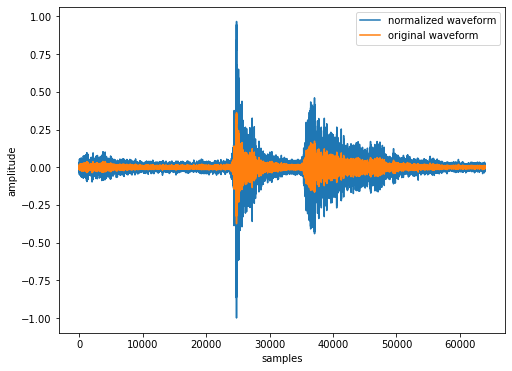

In [17]:
#plot the original spectrum, and the normalized version
f,ax = plt.subplots( figsize=(8,6) )
ax.plot( y, alpha=1.0, label='normalized waveform' );
ax.plot( wf_np, alpha=1.0, label='original waveform' );
#ax.plot( np.asfortranarray( wf_rs[0].numpy() ), alpha=0.6, label='original wf' );

#ax.plot( yr, alpha=0.6, label='recronstructed wf' );
ax.set_xlabel('samples')
ax.set_ylabel('amplitude')
ax.legend()

In [18]:
def FindPeaks(x, ax, height=0.6, output=True):
    peaks, _ = find_peaks(x, height=height*max(x), distance=5, width=3 )
    prominences = peak_prominences(x, peaks)[0]
    contour_heights = x[peaks] - prominences
    ax.plot(peaks, x[peaks], "x")
    ax.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
    #end peak finding
    #...just use max for now
    print(peaks, x[peaks])
    peak_order = sorted( zip( peaks, x[peaks] ), key=lambda l: l[1], reverse=True) 
    print(peak_order)#, x[ list(peak_order[0,:]) ])
    
    #plt.show()
    return peak_order #peaks, x[peaks]

In [19]:
def GetRMS(y):
    '''takes numpy array of normalized original sample'''
    rms = librosa.feature.rms(y=y)
    return rms.min(), rms.max(), rms.mean(), rms.std()

def GetFlatness( y ):
    '''same for normalized and non-normalized sample'''
    flatness = librosa.feature.spectral_flatness(y=y)
    return flatness.min(), flatness.max(), flatness.mean(), flatness.std()

def GetRolloff( y, sr ):
    '''normalized or non-normalzied give same results'''
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    return rolloff.min(), rolloff.max(), rolloff.mean(), rolloff.std()

def GetContrast( y, sr ):
    '''takes normalized sample (maybe normalized???)
    returns min, max, mean, std'''
    contrasts = librosa.feature.spectral_contrast(y=y, sr=sr)
    mins = [l.min() for l in contrasts]
    maxs = [l.max() for l in contrasts]
    means = [l.mean() for l in contrasts]
    stds = [l.std() for l in contrasts]
    #ranks = sorted( zip( range(7), contrasts.sum(1), mins, maxs, means, stds ), key=lambda l:l[1], reverse=True)
    ls = sorted( zip( range(7), contrasts.sum(1) ), key=lambda l:l[1], reverse=True)
    vals = list( zip( mins, maxs, means, stds ) )
    ranks = [l[0] for l in ls]
    return ranks, vals

def GetCentroids( y, sr ):
    cent = librosa.feature.spectral_centroid( y, sr )
    return cent.min(), cent.max(), cent.mean(), cent.std()

def GetBandwidth( y, sr ):
    bw = librosa.feature.spectral_bandwidth( y, sr )
    return bw.min(), bw.max(), bw.mean(), bw.std()

[ 25  46  69  86 110] [5915.60377331 6313.5699311  6040.92362123 5485.91485833 5773.31595454]
[(46, 6313.569931098754), (69, 6040.923621227654), (25, 5915.6037733110725), (110, 5773.315954535363), (86, 5485.91485832996)]
rms min 4656.086289497447, max 6313.460778693794, mean 5522.013030313298 std 338.2792677035653
rms min 4656.254833935665, max 6313.569931098754, mean 5522.215553652042 std 338.2433175680264


[(46, 6313.569931098754),
 (69, 6040.923621227654),
 (25, 5915.6037733110725),
 (110, 5773.315954535363),
 (86, 5485.91485832996)]

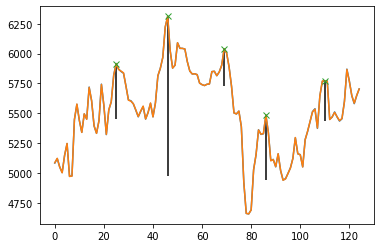

In [43]:
#look at the spectral centroids
cent = librosa.feature.spectral_centroid( wf_np, sr )
centN = librosa.feature.spectral_centroid( y, sr )

f,ax = plt.subplots()
ax.plot( cent[0], label='wf_np' )
ax.plot( centN[0], label='y (normalized)' )

pks = FindPeaks( centN[0], ax=ax )

print( f'rms min {cent.min()}, max {cent.max()}, mean {cent.mean()} std {cent.std()}')
print( f'rms min {centN.min()}, max {centN.max()}, mean {centN.mean()} std {centN.std()}')
pks

[39 87] [5269.03398313 4116.78478804]
[(39, 5269.033983130567), (87, 4116.7847880357685)]
rms min 1440.0346157882514, max 5709.772703841713, mean 3859.1610990856816 std 1335.659242345233
rms min 1439.86854280816, max 5709.77021794277, mean 3859.1362966641686 std 1335.6675625071882


((1, 125), [(39, 5269.033983130567), (87, 4116.7847880357685)])

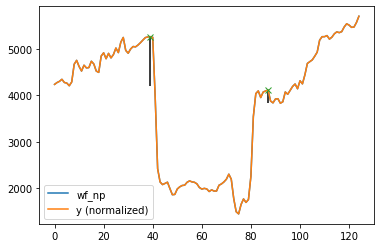

In [44]:
bw = librosa.feature.spectral_bandwidth( wf_np, sr )
bwN = librosa.feature.spectral_bandwidth( y, sr )

f,ax = plt.subplots()
ax.plot( bw[0], label='wf_np' )
ax.plot( bwN[0], label='y (normalized)' )
ax.legend()

pks = FindPeaks( bwN[0], ax=ax )

print( f'rms min {bw.min()}, max {bw.max()}, mean {bw.mean()} std {bw.std()}')
print( f'rms min {bwN.min()}, max {bwN.max()}, mean {bwN.mean()} std {bwN.std()}')
bw.shape, pks

[35 47] [0.286916   0.33343154]
[(47, 0.33343154), (35, 0.286916)]


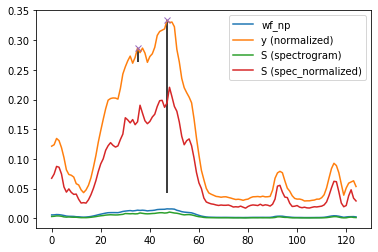

rms shape (1, 125)
rms min 0.0014159370912238955, max 0.01608916185796261, mean 0.005706441588699818 std 0.0047381860204041
rms min 0.029323499649763107, max 0.33343154191970825, mean 0.1182556003332138 std 0.09819614142179489


(0.0293235, 0.33343154, 0.1182556, 0.09819614)

In [42]:


rms = librosa.feature.rms(y=wf_np)
rmsN = librosa.feature.rms(y=y)
rmsS = librosa.feature.rms(S=S)
rmsSn = librosa.feature.rms(S=Sn)

f,ax = plt.subplots()
ax.plot( rms[0], label='wf_np' )
ax.plot( rmsN[0], label='y (normalized)' )
ax.plot( rmsS[0], label='S (spectrogram)' )
ax.plot( rmsSn[0],  label='S (spec_normalized)')
ax.legend()

FindPeaks( rmsN[0], ax=ax )
#FindPeaks( rmsN[0], ax=ax )
plt.show()

print('rms shape', rms.shape )
print( f'rms min {rms.min()}, max {rms.max()}, mean {rms.mean()} std {rms.std()}')
print( f'rms min {rmsN.min()}, max {rmsN.max()}, mean {rmsN.mean()} std {rmsN.std()}')

#np.average( rms ), np.average( rmsN ), np.average( rmsS ), np.average( rmsSn )
GetRMS( y )

In [5]:


flatness = librosa.feature.spectral_flatness(y=wf_np)
flatnessN = librosa.feature.spectral_flatness(y=y)
flatnessS = librosa.feature.spectral_flatness(S=S)
flatnessSn = librosa.feature.spectral_flatness(S=Sn)

f,ax = plt.subplots()
ax.plot( flatness[0], label='wf_np' )
ax.plot( flatnessN[0], label='y (normalized)' )
ax.plot( flatnessS[0], label='S (spectrogram)' )
ax.plot( flatnessSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()

print( f'rms min {flatnessN.min()}, max {flatnessN.max()}, mean {flatnessN.mean()} std {flatnessN.std()}')

#np.average( flatness ), np.average( flatnessN ), np.average( flatnessS ), np.average( flatnessSn )
#same for norm and non-norm versions
GetFlatness( y )

NameError: name 'wf_np' is not defined

In [6]:


rolloff = librosa.feature.spectral_rolloff(y=wf_np, sr=sr)
rolloffN = librosa.feature.spectral_rolloff(y=y, sr=sr)
rolloffS = librosa.feature.spectral_rolloff(S=S, sr=sr)
rolloffSn = librosa.feature.spectral_rolloff(S=Sn, sr=sr)

f,ax = plt.subplots()
ax.plot( rolloff[0], label='wf_np' )
ax.plot( rolloffN[0], label='y (normalized)' )
ax.plot( rolloffS[0], label='S (spectrogram)' )
ax.plot( rolloffSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()

print( f'rms min {rolloff.min()}, max {rolloff.max()}, \
mean {rolloff.mean()} std {rolloff.std()}')


#np.average( rolloff ), np.average( rolloffN ), np.average( rolloffS ), np.average( rolloffSn )
GetRolloff( y, sr )

NameError: name 'wf_np' is not defined

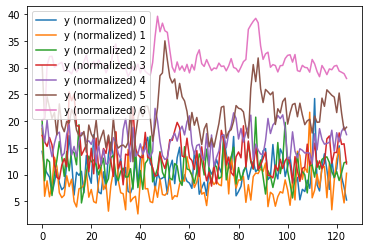

([6, 5, 4, 3, 2, 0, 1],
 (20.155182541788157,
  39.60249847957727,
  30.870273823875415,
  2.756140047560708),
 (12.400626788020615,
  35.002319848799594,
  21.124948641500495,
  4.126124891002746))

In [45]:


spec_contrast = librosa.feature.spectral_contrast( wf_np, sr )
spec_contrastN = librosa.feature.spectral_contrast( y, sr )
spec_contrastS = librosa.feature.spectral_contrast( S=S, sr=sr )
spec_contrastSn = librosa.feature.spectral_contrast( S=Sn, sr=sr )


f,ax = plt.subplots()
#ax.plot( spec_contrast[0], label='wf_np' )
for i in range(7):
    ax.plot( spec_contrast[i], label=f'y (normalized) {i}' )
#ax.plot( spec_contrastS[0], label='S (spectrogram)' )
#ax.plot( spec_contrastSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()
'''
for spec_contrast in spec_contrasts:
    print( f'rms min {spec_contrast.min()}, max {spec_contrast.max()}, \
    mean {spec_contrast.mean()} std {spec_contrast.std()}')
print( f'rms min {spec_contrastN.min()}, max {spec_contrastN.max()}, \
mean {spec_contrastN.mean()} std {spec_contrastN.std()}')
'''
#np.average( spec_contrast ), np.average( spec_contrastN ), np.average( spec_contrastS ), np.average( spec_contrastSn )
#same for norm and non-norm versions
ls, vals = GetContrast(wf_np, sr)#, spec_contrast.shape
#np.array(ls[0][2]).mean(), np.array(ls[1][2]).mean(), np.array(ls[2][2]).mean()
#ls[::1]
ls, vals[6], vals[5]

In [ ]:
ls = sorted( zip( range(7), spec_contrasts.sum(1), spec_contrasts ), key=lambda l:l[1], reverse=True)
avgs = [np.average(l[2]) for l in ls]
rank, avgs

In [ ]:
cepstral = librosa.feature.mfcc(y, sr)

for i in range(20):
    plt.plot(cepstral[i], label=i)
plt.legend()
    
plt.show()    
librosa.display.specshow(cepstral, y_axis='mel', x_axis='frames');#,x_axis='time'
plt.show()

cepstral.shape, np.average(cepstral[0]), np.average(cepstral[1]), np.average(cepstral[2])

In [ ]:
mfcc = torchaudio.transforms.MFCC( sample_rate=sr)(wf)


mfcc_np = mfcc.detach().numpy()[0]
librosa.display.specshow(mfcc_np, y_axis='mel', x_axis='frames');#,x_axis='time'
plt.show()
librosa.display.specshow(mfcc_np[:,:1], sr=sr, y_axis='mel', x_axis='frames');
plt.show()
mfcc.shape, type(mfcc), mfcc_np.shape, mfcc_np[:,:1]


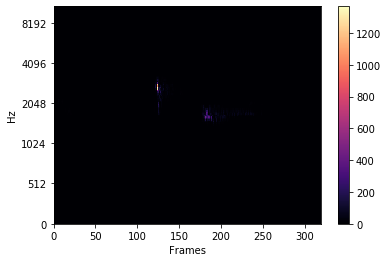

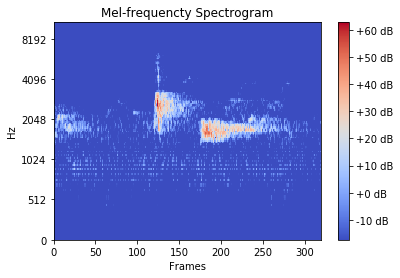

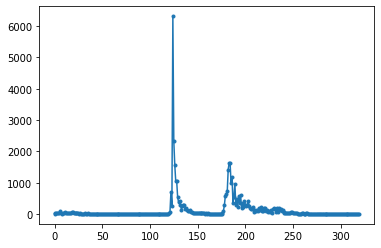

<Figure size 432x288 with 0 Axes>

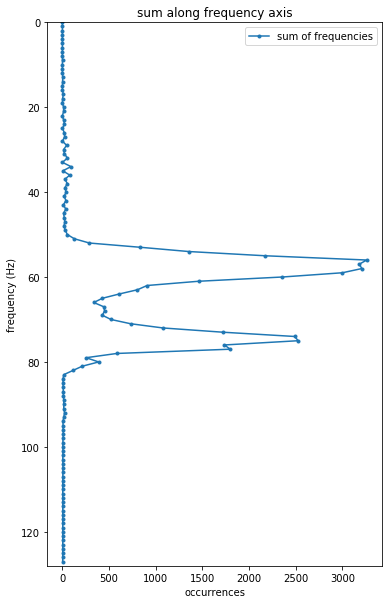

'\nplt.bar( range(len(amp)), amp )\nplt.show()\nplt.bar( range(len(freq)), freq )\nmel_specgram.shape\n'

In [85]:
from matplotlib.colors import LogNorm
from matplotlib import transforms
import pandas as pd

mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(yn)#(wf)
#plt.imshow( mel_specgram.detach().numpy()[0], norm=LogNorm() )

mel_np = mel_specgram.detach().numpy()[0]
mel_db = librosa.core.amplitude_to_db( mel_np )
librosa.display.specshow(mel_np, y_axis='mel', x_axis='frames', )#,x_axis='time'
plt.colorbar()
plt.show()

plt.figure()#figsize=(10,8))
librosa.display.specshow(mel_db, y_axis='mel', x_axis='frames', )#,x_axis='time'
plt.title('Mel-frequencty Spectrogram')
plt.colorbar(format='%+2.0f dB')
amp, freq = mel_np.sum(0), mel_np.sum(1)
plt.show()
plt.figure()
#ax = plt.subplot(2,1,1)
plt.plot(amp, '.-', label='sum of amplitudes')
plt.figure()
#ax = plt.subplot(2,1,2)
f,ax = plt.subplots( figsize=(6, 10) )
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(270)
ax.set_title('sum along frequency axis')
ax.plot(freq, '.-', label='sum of frequencies', transform=rot+base)
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('occurrences')
ax.set_ylim( -len(freq), 0 )
ax.set_yticklabels( (140,120,100,80,60,40,20,0) ) #np.linspace(120-20, 0, len( ax.get_yticklabels())+1 ))
plt.legend()
plt.show()
#fdf = pd.DataFrame( freq )
#fdf.plot(kind='bar')
#fdf.plot.bar()
#hdata = list(zip( range(len(amp)), amp ))
'''
plt.bar( range(len(amp)), amp )
plt.show()
plt.bar( range(len(freq)), freq )
mel_specgram.shape
'''

8

In [ ]:
spec_np = spectrogram.detach().numpy()[0]
librosa.display.specshow(spec_np, y_axis='log', x_axis='frames')#,x_axis='time'
plt.show()
spec_np

background filtering using mel-spectrogram

In [ ]:
p0 = librosa.feature.poly_features(S=S, sr=sr, order=0)
p1 = librosa.feature.poly_features(S=S, sr=sr, order=1)
p2 = librosa.feature.poly_features(S=S, sr=sr, order=2)

p0n = librosa.feature.poly_features(S=Sn, sr=sr, order=0)
p1n = librosa.feature.poly_features(S=Sn, sr=sr, order=1)
p2n = librosa.feature.poly_features(S=Sn, sr=sr, order=2)

f,ax = plt.subplots()
plt.plot( p0[0], label='p0' )
plt.plot( p1[1], label='p1'  )
plt.plot( p2[2], label='p2'  )
plt.plot( p0n[0], label='p0n' )
plt.plot( p1n[1], label='p1n'  )
plt.plot( p2n[2], label='p2n'  )
ax.legend()

x = p0[0]
peaks, _ = find_peaks(x, height=0.4*max(x), distance=10) #, prominence=5
print('peak list', peaks)
prominences = peak_prominences(x, peaks)[0]
contour_heights = x[peaks] - prominences
plt.plot( peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])

FindPeaks(x=p0[0], ax=ax)

In [5]:
# We recommend scaling y to the range [-2**31, 2**31[ before applying
# PCEN's default parameters. Furthermore, we use power=1 to get a
# magnitude spectrum instead of a power spectrum.

#y = wf_np
def MelSpectrogramFiltering(y, sr):
    M = librosa.feature.melspectrogram(y, sr=sr, power=1)
    print('M shape', M.shape)
    log_M = librosa.amplitude_to_db(M, ref=np.max)
    pcen_M = librosa.pcen(M * (2**31))
    plt.figure( figsize=(14,10))
    plt.subplot(2,1,1)
    librosa.display.specshow(log_M[:, 20:], x_axis='time', y_axis='mel')
    plt.title('log amplitude (dB)')
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(pcen_M[:, 20:], x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    #plt.plot( pcen_M[:, 20:].sum(1) )
    plt.plot( M[:,:].sum(1), label='original_M' )
    
    plt.plot( pcen_M[:,:].sum(1), label='pcen_M' )
    pcen_M[:, 20:] = 0
    plt.plot( pcen_M[:,:].sum(1), label='pcen_M first 20 cut' )
    plt.legend()
    M.shape
    return M

M = MelSpectrogramFiltering(y, sr)

NameError: name 'y' is not defined

In [ ]:
def Reconstruct(M, sr):
    #reconstruct the stft from the mel-spectrogram
    Sr = librosa.feature.inverse.mel_to_stft(M, sr)
    #reconstruct the original signal
    yr = librosa.griffinlim(Sr) #griffin transformation
    #yr = librosa.istft(Sr, hop_length=512)
    plt.figure()
    plt.subplot(3,1,1)
    librosa.display.specshow(Sr, x_axis='time', y_axis='log')
    plt.title('Reconstructed stft (dB)')
    plt.colorbar()
    #librosa.display.specshow(log_M, x_axis='time', y_axis='log')
    plt.subplot(3,1,2)
    #plt.plot( yr )
    plt.plot( Sr.sum(1) )
    plt.title('reconstructed audio')
    plt.colorbar()
    
    yr.shape, type( yr )
    plt.subplot(3,1,3)
    plt.plot(yr)
    plt.show()
    return yr
    
yr = Reconstruct(M, sr)

In [ ]:
def MelFilterCompare( M, pcen_M ):
    pcen_max = librosa.pcen(M * (2**31), max_size=3)
    plt.figure()
    plt.subplot(2,1,1)
    librosa.display.specshow(pcen_M, x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization (no max-filter)')
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(pcen_max, x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization (max_size=3)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

define a low frequency filter (high-pass)
- can also be used as a band-pass filter if a lowerfreq is also supplied as an argument

In [20]:

def ApplyFilter( Din, sr, upperfreq = 1020, lowerfreq=None ):
    '''high pass filter
    ci = 250 #~5000, ci = 125 #~2691, ci = 50 #~1000, ci = 40'''
    frequency_conversion = librosa.core.fft_frequencies(sr=sr)
    upper_index = np.abs(frequency_conversion - upperfreq).argmin()
    #print(f'upper frequency index, {upper_index} closest freq {frequency_conversion[upper_index]}')
    if lowerfreq is not None:
        lower_index = np.abs(frequency_conversion - lowerfreq).argmin()
        #print(f'lower frequency index, {lower_index} closest freq {frequency_conversion[lower_index]}')
    else:
        lower_index = 0
    Din[lower_index:upper_index,:] = np.zeros( (upper_index-lower_index, Din.shape[1]) )
    

In [ ]:
import os
os.getcwd()

#find the peak, cut two seconds and store in a new array temporarily...
#or if longer recording,take all of the peak samples, or the biggest 2, or 3, and get the most likely for all
#draw colored boxes around sample sections in the app interface

filter frequency 600
sr 44100
209.02017211914062 occurances, of index 128


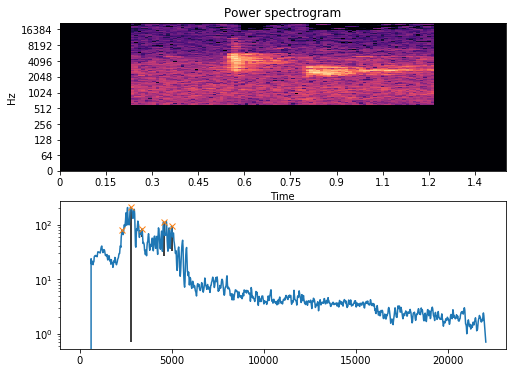

filter frequency 600
sr 44100
557.5006103515625 occurances, of index 128


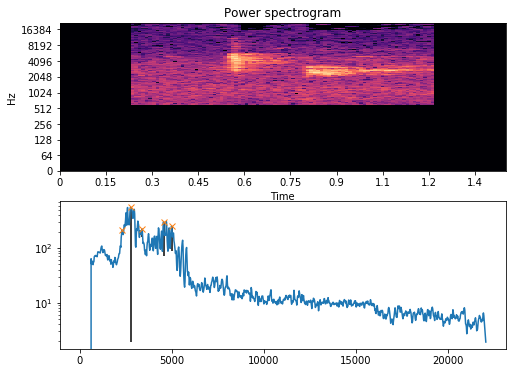

128

In [23]:
    
#function to get frequency bin with most entries (i.e. the Prominent Frequency)
def GetPromFreqIndex(y, sr, filt_Hz, output=False):
    
    #hop_length = 512
    D = np.abs(librosa.stft(y))
    #print('shape', D.shape)
    nc = 20
    D[:,:nc], D[:,-nc:] = 0, 0
    ####following lines are for testing
    
    if filt_Hz is not None:
        ApplyFilter(D, sr, filt_Hz)
    
    ####end testing lines, remove once completed, make a more succinct function
    freq_sum =  D.sum(1)
    
    #get the most prominent frequency index
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    
    if output:
        print('filter frequency', filt_Hz)
        print('sr', sr)
        #times = librosa.times_like(D)
        plt.figure( figsize=(8,6))
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)

        frequencies = librosa.core.fft_frequencies(sr=sr)
        plt.plot( frequencies , freq_sum )
    
    
        #plt.xscale('log') #use yaxis since we are summing the rows (frequencies)
        plt.yscale('log')
    
    
        print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
        #plot the prominences from the scipy example
        x = freq_sum
        
        try:
            #print('xshape', x.shape)
            peaks, _ = find_peaks(x, height=0.35*max(x), prominence=5, distance=20)
            #print('peak list', peaks)
            prominences = peak_prominences(x, peaks)[0]
            contour_heights = x[peaks] - prominences
            plt.plot(frequencies[peaks], x[peaks], "x")
            plt.vlines(x=frequencies[peaks], ymin=contour_heights, ymax=x[peaks])
        except Exception as e:
            print(e)
        
        plt.savefig('bad_plot.png')
        plt.show()
        #end peak finding
        #...just use max for now
    
        if len(peaks)>=2:
            peaks = peaks[:2]
        #if prom_freq in peaks:
            #peaks = list(peaks)
            #print('peaks', peaks )
        #    peaks.remove( prom_freq )
            #print('removing largest peak from secon peaks list...')

    return prom_freq#, peaks[0]    
    
def GetFreqRange( indexes, sample_rate ):
    #index = GetPromFreqIndex(y, sample_rate, FILTER=librosa.iirt)
    if type(indexes) == int:
        index = indexes
        return librosa.core.fft_frequencies(sr=sample_rate)[index:index+2] 
    
    res = []
    for index in indexes:
        res.append( librosa.core.fft_frequencies(sr=sample_rate)[index:index+2] )
    return res

D = np.abs(librosa.stft(wf_np))
ApplyFilter( D, sr=sr, upperfreq=1200, lowerfreq=500)
#GetPromFreqIndex(wf_np, sr, output=True)
#GetPromFreqIndex(wf_np, sr, filt_Hz=400, output=True)
GetPromFreqIndex(wf_np, sr, filt_Hz=600, output=True)
#pfi = GetPromFreqIndex(wf_np, sr, filt_Hz=2200, output=True)
GetPromFreqIndex(y, sr, filt_Hz=600, output=True)
#GetFreqRange( pfi, sr )



In [24]:
   
def GetPromMelFreqIndex(y, sr, filt_Hz=600, output=False):
    
    #hop_length = 512
    D = np.abs(librosa.feature.melspectrogram(y, sr=sr))
    D = np.abs( torchaudio.
    ApplyFilter(D, sr, upperfreq=filt_Hz )
    times = librosa.times_like(D)
    freq_sum =  D.sum(1)
    if output:
        print('sr', sr)
        plt.figure( figsize=(8,6) )
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='mel', x_axis='time')
        plt.title('Mel power spectrogram')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)
        
        plt.plot( freq_sum ) #no x-axis conversion to frequency
        plt.yscale('log')
        #plot the prominences from the scipy example
        x = freq_sum
        peaks, _ = find_peaks(x, height=0.25*max(x), prominence=5, distance=5)
        prominences = peak_prominences(x, peaks)[0]
        contour_heights = x[peaks] - prominences
        plt.plot(peaks, x[peaks], "x")
        plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
        #end peak finding
        #...just use max for now
        
        plt.show()
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    #print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
    
    return prom_freq

def ConstatQPower(y, sr, ymin='C3', filt_Hz=300, output=False):

    #hop_length = 512
    #D = librosa.cqt(y)
    D = np.abs(librosa.cqt(y, sr, fmin=librosa.note_to_hz(ymin) ) )
    ApplyFilter(D, sr, upperfreq=filt_Hz )
    times = librosa.times_like(D)
    freq_sum = D.sum(1)
    if output:
        print('sr', sr)
        plt.figure( figsize=(8,6) )
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='cqt_note', x_axis='time')

        plt.colorbar(format='%+2.0f dB')
        plt.title('Constant Q SPower spectrum')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)
        x = freq_sum
        peaks, _ = find_peaks(x, height=0.25*max(x))#
        , prominence=1, distance=2)
        print('Q peaks', peaks)
        prominences = peak_prominences(x, peaks)[0]
        contour_heights = x[peaks] - prominences
        plt.plot(peaks, x[peaks], "x")
        plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
        plt.plot( freq_sum )
        plt.yscale('log')
        plt.show()
        ##try inverse Q power transform
        
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    #print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
    return prom_freq


power spectrogram
filter frequency 600
sr 44100
209.02017211914062 occurances, of index 128


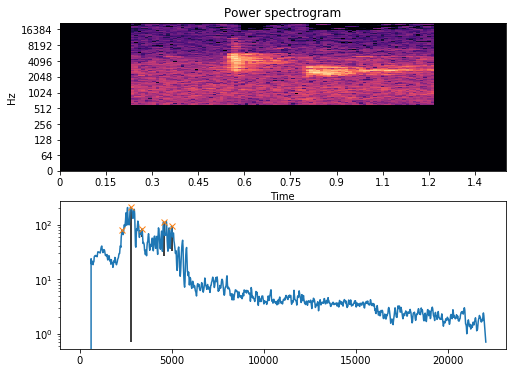

most prominent freq-rage [2756.25       2777.78320312]

constant q-value spectrogram
sr 44100
Q peaks [38 53 60]


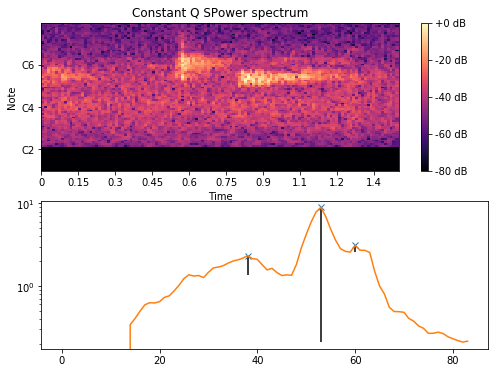


mel frequency spectrogram
sr 44100


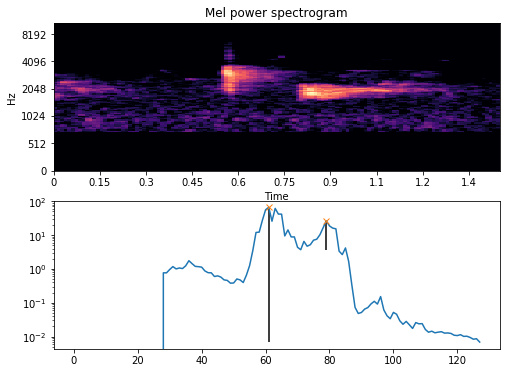

mel freq is [1853.16744504 1903.92117631]


In [25]:
print('power spectrogram')
###prom_freq_index, second_peak = GetPromFreqIndex(y=wf_np, sr=sr) #add on next pass
prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, filt_Hz=600, output=True)
freq_range = GetFreqRange( indexes=prom_freq_index, sample_rate=sr) 
###freq_range2 = GetFreqRange( index=second_peak, sample_rate=sr) 
##print('index', prom_freq_index,'peaks', second_peak)
print('most prominent freq-rage', freq_range) 
##print('most prominent freq-rage', freq_range2)
    
print('\nconstant q-value spectrogram')
prom_freq_index = ConstatQPower(y=wf_np, sr=sr, output=True)

print('\nmel frequency spectrogram')
#prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, FILTER=librosa.feature.melspectrogram, yaxis='linear')
prom_freq_index = GetPromMelFreqIndex(y=wf_np, sr=sr, output=True)
mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
print('mel freq is', mel_freq)

In [ ]:
#look at the phase anglelll
A = np.angle( librosa.stft(wf_np))
plt.imshow( A )
plt.show();
A.shape, D.shape
#plt.plot(A.sum(0) )
#plt.show()
#plt.plot( A.sum(1), D.sum(1), 'x' )

The following two cells detemine the 'loudest' moment of the audio.  
Then the fourier transform is computed for the 'hop_length'=2048 before and after that moment
The peak frequency in those single hop fourier transforms are useable features
...turn into a fucntion eventually...just the `D.sum(0)` and `max` of `amp_sum`

In [ ]:
#single 'loudest' moment (what is the fft there? and mel...)
D = np.abs(librosa.stft(wf_np))

amp_sum =  D.sum(0)
plt.plot( amp_sum )
prom_amp = amp_sum.tolist().index(max(amp_sum))
print(prom_amp)
times = librosa.times_like(D)
samples = librosa.samples_like(D)
times[ prom_amp ], samples[prom_amp], times[-1], samples[-1]

In [ ]:
#look at the single spectrum around this sample number
n_fft = 2048
#hop_length = n_fft+1
f, ax = plt.subplots()
ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                        hop_length=n_fft+1))
ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
prom_freq =  ft.tolist().index(max(ft))

slice_after = GetFreqRange( prom_freq, sample_rate=sr )

#look at the single spectrum around this sample number
n_fft = 2048
#hop_length = n_fft+1
ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-+n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))

#ax.plot(ft);
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Hz')
#ax.set_ylabel()
prom_freq = ft.tolist().index(max(ft))
slice_before = GetFreqRange( prom_freq, sample_rate=sr )

slice_before[0], slice_after[0]

In [9]:
def GetSingleSegmentFreq( wf_np, sr, prom_amp, n_slices, filt_Hz, samples, output=False ):
    n_fft = 2048
    #get freq i slices before peak
    #wf, sr = torchaudio.load( filepath )
    if output:
        ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                                hop_length=n_fft+1))

        #ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        prom_freq = ft.tolist().index(max(ft))
        slice_after = GetFreqRange( prom_freq, sample_rate=sr )
        #get freq after peak (i slaces before)
        #f,ax = plt.subplots()
    
        f = plt.figure()
        ax = plt.subplot(1, 1, 1)
        ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))

        prom_freq = ft.tolist().index(max(ft))
        slice_before = GetFreqRange( prom_freq, sample_rate=sr )

        #ax = plt.subplot(2, 1, 2)
        ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        #generalize

        plt.figure( figsize=(8,12) )
    gen_slices = []
    oset = 0
    for i in range(-n_slices-oset, n_slices-oset):
        si, ei = samples[prom_amp]+i*n_fft, samples[prom_amp]+(i+1)*n_fft #start index, end index
        #print(f'indecies used: si {si}, ei {ei}')
        #ft = np.abs( torchaudio.transforms.Spectrogram( n_fft=n_fft, hop_length=n_fft+1)(wf[si: ei]) )
                                 # hop_length=n_fft+1, pad_mode='constant') )
                                
        ft = np.abs( librosa.stft(wf_np[si: ei], n_fft=n_fft, hop_length=n_fft+1) )
                                 # hop_length=n_fft+1, pad_mode='constant') )
                                
        #print( 'shape', ft.shape )
        ApplyFilter( ft, sr, upperfreq=filt_Hz, lowerfreq=None )
        
        prom_freq = ft.tolist().index(max(ft))
        #print(f'prom freq index {prom_freq}')
        gen_freq = GetFreqRange( prom_freq, sample_rate=sr )
        gen_slices.append(gen_freq)
        if output:
            ax = plt.subplot(n_slices*2, 1, i+n_slices+1+oset)
            ax.plot( librosa.core.fft_frequencies(sr=sr), ft ) #plot 1D spectra of freqency vs occurance
            #librosa.display.specshow(ft, sr=sr, y_axis='log', x_axis='time')
            ax.set_xlabel('Hz')
            plt.suptitle('fourier spectrum around peak volume')#, y=0.94)
            plt.tight_layout()
    return gen_slices
    #return slice_before, slice_after, gen_slices #for testing consistency

def GetSlicesAroundPeakVolume( wf_np, sr, n_slices, filt_Hz=1020, output=False ):
    '''get the prominent frequencies of single stft slices
    choose the number before and after'''
    #take the stft of entire spectrum
    
    D = np.abs(librosa.stft(wf_np))
    samples = librosa.samples_like(D)
    ApplyFilter( D, sr, upperfreq = filt_Hz )
    amp_sum =  D.sum(0) #sum along the "time" axis, to get the peaks in volume
    if output:
        plt.figure( figsize=(8,6) )
        ax = plt.subplot(2, 1, 1)
        #librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='log', x_axis='time')
        #get the loudest location's index
        ax = plt.subplot(2, 1, 2)
    
        plt.plot( amp_sum )
    
    
    prom_amp = amp_sum.tolist().index(max(amp_sum))
    return GetSingleSegmentFreq( wf_np, sr, prom_amp, n_slices, filt_Hz=filt_Hz, samples=samples, output=output )
    

#GetSlicesAroundPeakVolume( wf_np, sr, n_slices=3, filt_Hz=900, output=True)
#later get spacing between two largest peaks

In [ ]:
type( ( 10 ,))

In [ ]:
for i in range(-4,4+1):
    print(i)

Fourier Transform on the entire spectrum using scipy

In [10]:
def TotalFourierPeak( y, filt_Hz=400, output=False ):
    fourier = scipy.fft( y )
    N = len(y)
    y2 = fourier[:int(N/2)]/N
    y2_abs = np.abs(y2)
    y2_abs[:filt_Hz] = 0
    
    #ApplyFilter([y2_abs], sr, upperfreq=200)
    y2max, y2max_abs = max(y2), max(y2_abs)
    i_y2max, i_y2max_abs = y2.tolist().index(max(y2)), y2_abs.tolist().index(max(y2_abs))
    
    if output:
        print(f'max {max(y2)}, position: {y2.tolist().index(max(y2))} ' )
        print( y2max_abs)
        f,ax = plt.subplots( figsize=(14,10) )
        #ax.plot( y2 )
        
        ax.plot( y2_abs )
        ax.plot( i_y2max_abs,  y2max_abs, 'x')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Hz')
        ax.set_ylabel('occurances')
        ax.set_title('total fourier transform')
        #ax.vlines( i_y2max_abs, 0,  y2max_abs  )
        print( y2max, y2max_abs )
    return i_y2max_abs


#f_peak = TotalFourierPeak( wf_np, output=True )
#f_peak


In [ ]:
a = ([0],
    [2])
x = np.array( a )
y = np.array( (0,1,2) )
y = x
try:
    pritn(y.shape[1])
    print(y.max())
    
except:
    print(y.shape[0])
    print(y.max())

In [ ]:
#plt.plot( np.abs(fourier) );
fourier = scipy.fft( wf_np )
N = len(wf_np)

y2 = fourier[:int(N/2)]/N
ySS = y2[1:] = 2*y2[1:]
#y2 = fourier
f,ax = plt.subplots(3,1, sharex=True)
ax[0].plot( np.abs( fourier ));
ax[1].plot( np.abs( y2 ));
ax[2].plot( np.abs( ySS ))

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    
print(f'max ss{max(ySS)}, position: {ySS.tolist().index(max(ySS))} ' )
#print(f'max {max(y2)}, position: {y2.tolist().index(max(y2))} ' )


rework to have the contrast vales for te different bands always with their index
- i.e. badn 6 min, max, mean, std always same position

In [18]:
##libs needed:
#torchaudio
#librosa

##fucntions needed:
#GetPromFreqIndex
#GetFreqRange
#ConstantQPower
#GetPromMelFreqIndex
#librosa.core.mel_frequencies
#TotalFourierPeak
#GetSlicesAroundPeakVolume
def GetParamsForFile( file, path, flt=False ):
    '''get the params to feed into:
        - the .csv f.write() funciton 
        - the model as a row for the predict" method '''
    filename = os.path.join( path, file )
    wf, sr = torchaudio.load( filename )
    wf_np = np.asfortranarray( wf[0].numpy() )
    
    #get the prominent freq range from stft
    prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, filt_Hz=600)
    prom_freq_range = GetFreqRange( indexes=prom_freq_index, sample_rate=sr) 
    #get constant Q freq
    prom_Q_freq = ConstatQPower(y=wf_np, sr=sr)
    #get mel freq maximum
    prom_freq_index = GetPromMelFreqIndex(y=wf_np, sr=sr)
    mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
    #get the most prominent frequency from the total fourier transform
    fourier_freq = TotalFourierPeak( wf_np )
    #get the frequencies from the slices around the peak volume
    slice_freqs = GetSlicesAroundPeakVolume(wf_np, sr, n_slices=3, filt_Hz=900)
    #new, added features
    wfN = Normalize( wf ) 
    y = np.asfortranarray( wf[0].numpy() )
    rms = list( GetRMS( y ) )
    flat = list( GetFlatness( y ) )
    rolloff = list( GetRolloff(y, sr) )
    centroids = list( GetCentroids( y, sr ) )
    bandwidths = list( GetBandwidth( y, sr ) )
    
    cont_ranks, contrasts =  GetContrast(y, sr)[:3]
    #conts = contrasts[:3]
    #print(conts[0])
    
    #get the species name from the filename string, this is the target value
    species_name = file.split('_')
    species_name = species_name[0]
    
    param_list = [ prom_freq_range[0], prom_Q_freq, mel_freq[0], fourier_freq ] +\
        [sf[0] for sf in slice_freqs] +\
        rms + flat + rolloff + centroids + bandwidths+\
        cont_ranks +\
        list(contrasts[6]) + list(contrasts[5]) + list(contrasts[4])+ list(contrasts[3]) +\
        list(contrasts[2]) + list(contrasts[1]) + list(contrasts[0]) +\
        [wf_np.shape[0], sr, species_name ]
    #string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
                    #{times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr}, {species_name} \n' 
    
    return param_list            
    
    
    #get equivilent times and sample arrays

    '''
    #combine the answers to create the string we will be writing
    string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
    {times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr},{species_name}\n' 
    #f.write( string_to_write )
    ret = string_to_write.strip().split(',')
    #print(ret, len(ret)) #uncomment for testing
    to_rem = -1*( len( ret ) - 9  )
    #print(to_rem) #uncomment for testing
    ret = ret[:to_rem]
    ret = [float(r) for r in ret]
    
    return ret
'''
file = os.path.join( path, files[1001] )
pars = GetParamsForFile( file, path )
pars, len(pars)

([3164.0625,
  55,
  2121.2222434897826,
  4518,
  1101.5625,
  3187.5,
  3164.0625,
  3187.5,
  3023.4375,
  2859.375,
  0.0011650039,
  0.15782984,
  0.03120755,
  0.046187542,
  2.1014691e-06,
  0.024578407,
  0.007777903,
  0.008215524,
  2484.375,
  9960.9375,
  6208.0078125,
  2792.131606836282,
  2163.8939360619943,
  4810.253751531995,
  3672.3120068697726,
  692.626832756805,
  757.2969103941707,
  4692.865180545092,
  3120.577924951068,
  1379.997642103525,
  6,
  4,
  5,
  3,
  0,
  2,
  1,
  22.59945664980125,
  32.554228927397595,
  25.089769982459377,
  2.1429176794708025,
  10.611921964117439,
  50.7748683731066,
  22.064238471671654,
  9.05503439965592,
  9.53503803374651,
  41.08064362948048,
  22.29316024574146,
  7.3716388453022175,
  7.383054096238728,
  27.33464269747713,
  12.854138162673612,
  3.420138437337037,
  4.345080480409878,
  28.3420675106288,
  11.005365200183576,
  3.5452142806624662,
  3.819072085876222,
  24.5595243123245,
  10.741583571580744,
  3.6

('Rufous Hummingbird_5_3.wav',
 '/home/chris/Documents/Insight2020/birdsounder-model/../examples/cutclips')

In [10]:
species = [
    ('American Robin', 281),
    ('American Crow', 20),
    ('American Goldfinch', 286),
    ('Bald Eagle', 68),
    ('Blue Jay', 182),
    ('Brown-headed Cowbird', 230),
    ('Carolina Chickadee', 53),
    ('Canada Goose', 238),
    ('Eastern Bluebird', 243),
    ('Indigo Bunting', 264),
    ('Mallard', 101),
    ('Purple Finch', 233),
    ('Red-winged Blackbird', 138), #file 72 is a good example
    ('Rose-breasted Grosbeak', 186), #file 10
    ('Tufted Titmouse', 78), #file 5 good example (file 0 bad sound at end file 4 bad at beginning)
    ('Scarlet Tanager', 29)
]

species_list = [spec for spec,n in species]
species_list

['American Robin',
 'American Crow',
 'American Goldfinch',
 'Bald Eagle',
 'Blue Jay',
 'Brown-headed Cowbird',
 'Carolina Chickadee',
 'Canada Goose',
 'Eastern Bluebird',
 'Indigo Bunting',
 'Mallard',
 'Purple Finch',
 'Red-winged Blackbird',
 'Rose-breasted Grosbeak',
 'Tufted Titmouse',
 'Scarlet Tanager']

In [23]:
#function to write a CSV file to feed into pandas, then the ML model
def WriteCSV( files, path ):
    with open('bird_train.csv', 'w+') as f:
        #write headers line
        headers_string = 'peak_Hz,peak_Q,peak_mel,fourier_freq,\
        ampmax_n3,ampmax_n2,ampmax_n1,ampmax_0,ampmax_p1,ampmax_p2,\
        rms_min,rms_max,rms_mean,rms_std,flat_min,flat_max,flat_mean,flat_std,\
        rolloff_min,rolloff_max,rolloff_mean,rolloff_std,\
        centroid_min,centroid_max,centroid_mean,centroid_std,\
        bandwidth_min,bandwidth_max,bandwidth_mean,bandwidth_std,\
        band_cont0,band_cont1,band_cont2,band_cont3,band_cont4,band_cont5,band_cont6,\
        min_cont6,max_cont6,mean_cont6,std_cont6,\
        min_cont5,max_cont5,mean_cont5,std_cont5,\
        min_cont4,max_cont4,mean_cont4,std_cont4,\
        min_cont3,max_cont3,mean_cont3,std_cont3,\
        min_cont2,max_cont2,mean_cont2,std_cont2,\
        min_cont1,max_cont1,mean_cont1,std_cont1,\
        min_cont0,max_cont0,mean_cont0,std_cont0,\
        num_samples,sample_rate,species\n' #for n_points = 5
        #print('headers len', len(headers_string.split(',')))
        f.write( headers_string )
        exception_list = []
        for i,file in enumerate(files):
            try:
                param_list = GetParamsForFile( file, path )
                string_to_write = ','.join( [str(pl) for pl in param_list]  )
                f.write( string_to_write )
                f.write('\n')

            except Exception as e:
                exception_list.append( e )
                #raise e
                print(i)
                print('failed to process', file, 'due to exception', e)
            
            #if i==1: break
        f.close()  
    return exception_list
            

In [20]:
import os
cwd = os.getcwd()
path =  os.path.join( cwd, '../examples/cutclips' )
files = [f for f in os.listdir( path )]
print('number of files', len(files) )

number of files 63162


In [ ]:
## loop through all files in species_list, and write your .CSV file to feed the model
filesin = []
for file in files:
    for spec in species_list:
        if spec in file:
            filesin.append( file )

print('number of files', len(filesin) )

In [24]:

#WriteCSV( filesin, path ) #just species list
WriteCSV( files, path ) #all clip files (60k)


12
failed to process Northern Flicker_27_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15
failed to process Red-bellied Woodpecker_86_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23
failed to process White-crowned Pigeon_4_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24
failed to process Cabot's Tern_4_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37
failed to process Grey Catbird_3_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45
failed to process Carolina Wren_2_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
70
failed to process Carolina Wren_132_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
77
failed to process Song Sparrow_49_3.wav due to exception c

774
failed to process Common Loon_3_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
790
failed to process Bachman's Sparrow_8_7.wav due to exception Filter pass-band lies beyond Nyquist
793
failed to process Carolina Wren_174_36.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
797
failed to process White-crowned Pigeon_0_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
829
failed to process House Finch_1_4.wav due to exception Filter pass-band lies beyond Nyquist
834
failed to process Barred Owl_39_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
843
failed to process Least Tern_43_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
844
failed to process Bobolink_1_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
866
failed

1606
failed to process Bachman's Sparrow_8_2.wav due to exception Filter pass-band lies beyond Nyquist
1615
failed to process Black-and-white Warbler_87_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1624
failed to process Scarlet Tanager_30_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1625
failed to process American Tree Sparrow_15_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1637
failed to process Eastern Wood Pewee_34_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1644
failed to process Blue Grosbeak_0_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1663
failed to process Worm-eating Warbler_20_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1713
failed to process Purple Finch_43_5.wav due to exception 

2326
failed to process Black-throated Green Warbler_26_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2351
failed to process Lesser Yellowlegs_4_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2375
failed to process Winter Wren_48_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2376
failed to process Bald Eagle_12_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2417
failed to process Baltimore Oriole_14_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2448
failed to process Indigo Bunting_80_7.wav due to exception Filter pass-band lies beyond Nyquist
2454
failed to process Grey Catbird_2_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2484
failed to process Grey Catbird_117_5.wav due to exception can't extend empt

3121
failed to process Dickcissel_35_25.wav due to exception Filter pass-band lies beyond Nyquist
3144
failed to process Willow Flycatcher_48_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3177
failed to process Dickcissel_35_11.wav due to exception Filter pass-band lies beyond Nyquist
3186
failed to process Prothonotary Warbler_3_1.wav due to exception Filter pass-band lies beyond Nyquist
3218
failed to process Scarlet Tanager_10_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3221
failed to process Chipping Sparrow_9_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3241
failed to process Dickcissel_35_8.wav due to exception Filter pass-band lies beyond Nyquist
3246
failed to process House Wren_26_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3248
failed to process Brown Thrasher_6_11.wav due to except

3860
failed to process Tufted Titmouse_94_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3869
failed to process Northern Flicker_41_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3886
failed to process Spotted Sandpiper_19_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3891
failed to process Golden-winged Warbler_35_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3893
failed to process Dickcissel_35_14.wav due to exception Filter pass-band lies beyond Nyquist
3895
failed to process Tree Swallow_14_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3914
failed to process Blue Jay_157_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3940
failed to process Least Tern_26_5.wav due to exception can't extend empty axis 0

4801
failed to process Orange-crowned Warbler_13_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4802
failed to process Semipalmated Plover_21_21.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4806
failed to process Wood Duck_19_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4816
failed to process Black Tern_0_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4819
failed to process Marsh Wren_23_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4876
failed to process Ruby-crowned Kinglet_26_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4879
failed to process Common Grackle_28_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4892
failed to process Black-and-white Warbler_

5667
failed to process Red-tailed Hawk_6_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5726
failed to process Winter Wren_50_7.wav due to exception Filter pass-band lies beyond Nyquist
5767
failed to process Pine Warbler_3_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5769
failed to process Chestnut-sided Warbler_2_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5777
failed to process Marsh Wren_35_2.wav due to exception Filter pass-band lies beyond Nyquist
5785
failed to process Nashville Warbler_9_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5807
failed to process Common Yellowthroat_14_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5813
failed to process Myrtle Warbler_48_10.wav due to exception can't extend empty axis 0 using modes other than 'con

6590
failed to process Brown Creeper_26_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6599
failed to process Great Crested Flycatcher_22_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6606
failed to process Northern Cardinal_115_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6629
failed to process Tennessee Warbler_8_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6635
failed to process Loggerhead Shrike_4_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6636
failed to process Black-throated Blue Warbler_45_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6650
failed to process Eastern Towhee_144_1.wav due to exception Filter pass-band lies beyond Nyquist
6651
failed to process Prothonotary Warbler_11_2.wav du

7352
failed to process Ovenbird_18_2.wav due to exception Filter pass-band lies beyond Nyquist
7385
failed to process American Robin_24_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7393
failed to process Winter Wren_7_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7403
failed to process Red-shouldered Hawk_1_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7407
failed to process Song Sparrow_80_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7421
failed to process Hairy Woodpecker_40_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7422
failed to process Field Sparrow_58_22.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7427
failed to process House Finch_15_9.wav due to exception Filter pass-band lies beyond Nyqui

8219
failed to process American Robin_87_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8225
failed to process Eastern Bluebird_39_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8231
failed to process White-throated Sparrow_11_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8252
failed to process Northern Parula_11_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8259
failed to process Bonaparte's Gull_15_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8261
failed to process Blue Grosbeak_37_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8266
failed to process Limpkin_25_3.wav due to exception Filter pass-band lies beyond Nyquist
8267
failed to process Brown Thrasher_46_8.wav due to exception can't extend empty 

8977
failed to process Ring-billed Gull_18_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8988
failed to process Common Gallinule_48_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
8993
failed to process American Yellow Warbler_6_25.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9016
failed to process Northern Cardinal_43_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9020
failed to process Worm-eating Warbler_1_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9036
failed to process Field Sparrow_30_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9040
failed to process Mourning Warbler_25_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9044
failed to process American Oy

9679
failed to process Canada Goose_2_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9695
failed to process Yellow-billed Cuckoo_25_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9703
failed to process Black-capped Chickadee_9_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9730
failed to process Winter Wren_47_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9731
failed to process Western Osprey_30_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9754
failed to process Blue Jay_1_1.wav due to exception Filter pass-band lies beyond Nyquist
9775
failed to process Red-tailed Hawk_5_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
9780
failed to process Brown Thrasher_18_7.wav due to exception can't extend empty axis

10404
failed to process Black-necked Stilt_4_20.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10429
failed to process Grey Catbird_96_3.wav due to exception Filter pass-band lies beyond Nyquist
10441
failed to process Northern Flicker_28_32.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10449
failed to process Purple Gallinule_14_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10451
failed to process Black-and-white Warbler_62_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10467
failed to process Brown Creeper_8_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10475
failed to process Carolina Wren_184_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
10487
failed to process Eastern Wood Pewee_18_3.wav due to exception

11173
failed to process Red-winged Blackbird_25_19.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11184
failed to process American Yellow Warbler_50_7.wav due to exception Filter pass-band lies beyond Nyquist
11195
failed to process Tufted Titmouse_121_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11212
failed to process Common Starling_21_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11230
failed to process Buff-bellied Hummingbird_1_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11248
failed to process Barred Owl_10_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11259
failed to process Northern Parula_85_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
11276
failed to process Marsh Wren_18_2.wav due to excep

12127
failed to process Northern Saw-whet Owl_10_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12133
failed to process Chipping Sparrow_9_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12134
failed to process Mallard_8_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12161
failed to process Chestnut-sided Warbler_6_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12188
failed to process White-throated Sparrow_22_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12256
failed to process Northern Parula_86_0.wav due to exception Filter pass-band lies beyond Nyquist
12286
failed to process Harris's Sparrow_1_4.wav due to exception Filter pass-band lies beyond Nyquist
12288
failed to process Northern Mockingbird_25_1.wav due to exception Filter pass-band lies beyo

12889
failed to process Eastern Screech Owl_5_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12890
failed to process Northern Cardinal_140_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12914
failed to process Sedge Wren_32_0.wav due to exception Filter pass-band lies beyond Nyquist
12916
failed to process Northern Flicker_28_38.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12947
failed to process Common Starling_7_4.wav due to exception Filter pass-band lies beyond Nyquist
12956
failed to process Laughing Gull_1_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12958
failed to process Blue Jay_17_2.wav due to exception Filter pass-band lies beyond Nyquist
12964
failed to process Worm-eating Warbler_20_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
12966
fail

13587
failed to process House Finch_20_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13630
failed to process Cape May Warbler_15_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13632
failed to process Seaside Sparrow_2_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13636
failed to process White-crowned Sparrow_8_12.wav due to exception Filter pass-band lies beyond Nyquist
13644
failed to process Marsh Wren_36_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13649
failed to process Ruby-throated Hummingbird_8_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13656
failed to process Cape May Warbler_11_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
13666
failed to process Willow Flycatcher_13_16.wav due to exception

14528
failed to process Field Sparrow_75_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14560
failed to process Canada Warbler_25_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14564
failed to process Red-winged Blackbird_55_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14568
failed to process Brown-headed Nuthatch_23_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14572
failed to process Prothonotary Warbler_3_2.wav due to exception Filter pass-band lies beyond Nyquist
14574
failed to process American White Ibis_3_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14611
failed to process Barred Owl_16_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
14619
failed to process Bachman's Sparrow_19_0.wav due to excepti

15212
failed to process House Wren_9_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15223
failed to process Western Cattle Egret_14_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15224
failed to process Mottled Duck_4_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15226
failed to process Scarlet Tanager_25_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15246
failed to process Least Bittern_12_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15258
failed to process Marsh Wren_55_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15261
failed to process Pileated Woodpecker_37_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15271
failed to process Common Starling_0_1.wav

15874
failed to process Blue Jay_161_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15882
failed to process American Yellow Warbler_2_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15930
failed to process Eastern Bluebird_27_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15942
failed to process Chipping Sparrow_10_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15945
failed to process Song Sparrow_22_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15957
failed to process Northern Cardinal_161_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15970
failed to process Bobolink_37_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
15980
failed to process Downy Woodpecker_7_

16581
failed to process Connecticut Warbler_11_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16595
failed to process Red-breasted Nuthatch_28_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16611
failed to process Swamp Sparrow_18_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16620
failed to process Scarlet Tanager_42_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16624
failed to process Bobolink_38_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16630
failed to process Grey Catbird_22_34.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16644
failed to process Blue Grosbeak_0_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
16647
failed to process Carolina Wren_161_6.w

17396
failed to process Blue Jay_28_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17398
failed to process Red-breasted Nuthatch_31_19.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17402
failed to process Blue-grey Gnatcatcher_15_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17410
failed to process Black-crowned Night Heron_14_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17435
failed to process Wood Duck_20_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17437
failed to process Nanday Parakeet_2_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17438
failed to process Baltimore Oriole_44_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
17465
failed to process America

18166
failed to process Rose-breasted Grosbeak_1_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18174
failed to process Bachman's Sparrow_19_1.wav due to exception Filter pass-band lies beyond Nyquist
18187
failed to process Tundra Swan_0_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18232
failed to process Barred Owl_24_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18233
failed to process Red-tailed Hawk_6_32.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18243
failed to process Carolina Wren_142_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18263
failed to process Carolina Wren_148_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
18270
failed to process Northern Mockingbird_22_26.wav due to exception can't 

19031
failed to process American Crow_65_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19039
failed to process Yellow-breasted Chat_21_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19054
failed to process Warbling Vireo_6_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19057
failed to process White-crowned Sparrow_8_2.wav due to exception Filter pass-band lies beyond Nyquist
19092
failed to process Brown Thrasher_15_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19099
failed to process Double-crested Cormorant_18_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19107
failed to process Red Fox Sparrow_48_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19115
failed to process Northern Cardinal_123_4.wav due to ex

19760
failed to process Eastern Screech Owl_7_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19775
failed to process Carolina Wren_183_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19783
failed to process Red-breasted Nuthatch_38_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19819
failed to process Black-and-white Warbler_83_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19825
failed to process Caspian Tern_4_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19827
failed to process Mute Swan_0_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
19842
failed to process Red-bellied Woodpecker_84_2.wav due to exception Filter pass-band lies beyond Nyquist
19859
failed to process Nashville Warbler_30_4.wav due to excep

20542
failed to process Sandhill Crane_16_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20549
failed to process Acadian Flycatcher_1_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20560
failed to process House Finch_27_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20574
failed to process Eastern Wood Pewee_34_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20594
failed to process Egyptian Goose_0_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20601
failed to process Chipping Sparrow_76_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20615
failed to process Common Yellowthroat_103_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
20625
failed to process Brant Goose_

21498
failed to process Tufted Titmouse_68_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21512
failed to process House Finch_1_0.wav due to exception Filter pass-band lies beyond Nyquist
21515
failed to process Mallard_2_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21523
failed to process Marsh Wren_13_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21530
failed to process Marsh Wren_49_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21532
failed to process White-crowned Pigeon_0_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21540
failed to process American Goldfinch_25_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
21577
failed to process Northern Flicker_14_6.wav due to exception can't extend empty axis 0

22285
failed to process Dark-eyed Junco_11_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22331
failed to process White-eyed Vireo_74_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22337
failed to process Eastern Whip-poor-will_25_38.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22352
failed to process White-crowned Pigeon_0_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22384
failed to process Summer Tanager_2_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22388
failed to process Bahama Mockingbird_4_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22419
failed to process Bobolink_25_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
22439
failed to process Swainson's

23179
failed to process Red-breasted Nuthatch_30_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23195
failed to process Tennessee Warbler_23_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23218
failed to process Boat-tailed Grackle_21_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23223
failed to process Black-necked Stilt_4_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23243
failed to process Bobolink_22_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23251
failed to process Song Sparrow_10_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23259
failed to process Common Starling_5_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
23267
failed to process Red Fox Spar

24113
failed to process Marsh Wren_35_13.wav due to exception Filter pass-band lies beyond Nyquist
24125
failed to process Blue-winged Warbler_46_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24129
failed to process Indigo Bunting_18_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24131
failed to process Northern Cardinal_147_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24134
failed to process Black-billed Cuckoo_4_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24155
failed to process Bobolink_41_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24169
failed to process Tennessee Warbler_6_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24177
failed to process Blue Jay_110_0.wav due to exception can't extend em

24889
failed to process House Finch_24_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24891
failed to process Hooded Warbler_21_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24892
failed to process Northern Saw-whet Owl_2_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24903
failed to process Black-and-white Warbler_45_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24964
failed to process Chipping Sparrow_87_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24965
failed to process House Sparrow_4_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
24970
failed to process American Crow_41_2.wav due to exception Filter pass-band lies beyond Nyquist
24978
failed to process Orchard Oriole_46_2.wav due to exception can't 

25598
failed to process Boreal Owl_0_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25603
failed to process Yellow-billed Cuckoo_18_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25610
failed to process Sedge Wren_28_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25615
failed to process Brown-headed Nuthatch_27_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25618
failed to process Swamp Sparrow_24_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25704
failed to process Hairy Woodpecker_13_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25712
failed to process Marsh Wren_30_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
25768
failed to process Monk Parakeet_0_0.wav

26352
failed to process Red-winged Blackbird_55_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26353
failed to process Yellow-throated Warbler_20_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26361
failed to process Baltimore Oriole_58_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26366
failed to process Carolina Chickadee_34_3.wav due to exception Filter pass-band lies beyond Nyquist
26386
failed to process Rose-breasted Grosbeak_15_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26389
failed to process Louisiana Waterthrush_33_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26390
failed to process Black-billed Cuckoo_5_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
26423
failed to process Orchard Oriole_8_8

27272
failed to process Northern Cardinal_62_18.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27299
failed to process Common Grackle_16_27.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27301
failed to process American Woodcock_27_21.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27334
failed to process Florida Scrub Jay_9_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27340
failed to process American Yellow Warbler_30_24.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27345
failed to process House Finch_1_16.wav due to exception Filter pass-band lies beyond Nyquist
27362
failed to process Blue-winged Warbler_8_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
27377
failed to process White-eyed Vireo_1_4.wav due to exc

28188
failed to process Yellow-throated Vireo_12_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28226
failed to process White-throated Sparrow_45_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28227
failed to process American Crow_64_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28267
failed to process Palm Warbler_12_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28268
failed to process Baltimore Oriole_10_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28271
failed to process White-crowned Pigeon_3_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28276
failed to process House Wren_42_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
28295
failed to process Zenaida D

29012
failed to process Yellow-throated Warbler_38_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29018
failed to process Virginia Rail_6_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29028
failed to process Bachman's Sparrow_22_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29046
failed to process Semipalmated Sandpiper_5_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29062
failed to process Barred Owl_5_18.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29080
failed to process Eastern Towhee_37_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29083
failed to process Common Yellowthroat_26_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29106
failed to process Northe

29733
failed to process Black-and-white Warbler_22_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29742
failed to process Song Sparrow_33_22.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29780
failed to process Field Sparrow_29_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29784
failed to process American Robin_87_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29792
failed to process White-crowned Sparrow_8_9.wav due to exception Filter pass-band lies beyond Nyquist
29794
failed to process Killdeer_30_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
29817
failed to process Winter Wren_29_9.wav due to exception Filter pass-band lies beyond Nyquist
29836
failed to process American Yellow Warbler_39_2.wav due to exception Filter pass-band lies beyond Nyquist
2

30501
failed to process Blue-winged Warbler_46_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30503
failed to process American Coot_21_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30504
failed to process Northern Cardinal_75_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30580
failed to process Chestnut-sided Warbler_37_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30588
failed to process Eastern Phoebe_33_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30610
failed to process White-eyed Vireo_96_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30640
failed to process Great Crested Flycatcher_76_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
30660
failed to proc

31308
failed to process White-breasted Nuthatch_35_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
31366
failed to process Marsh Wren_35_14.wav due to exception Filter pass-band lies beyond Nyquist
31391
failed to process Carolina Wren_70_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
31392
failed to process Sora_8_1.wav due to exception Filter pass-band lies beyond Nyquist
31394
failed to process Blue-winged Teal_8_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
31395
failed to process Tufted Titmouse_94_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
31397
failed to process Hairy Woodpecker_10_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
31435
failed to process Yellow-billed Cuckoo_13_19.wav due to exception can't extend empty axis 0 using modes other t

32287
failed to process Prairie Warbler_4_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32289
failed to process Carolina Wren_181_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32291
failed to process Eastern Towhee_150_1.wav due to exception Filter pass-band lies beyond Nyquist
32299
failed to process Blue-winged Warbler_7_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32323
failed to process American Robin_97_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32330
failed to process Marsh Wren_22_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32334
failed to process House Sparrow_15_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32339
failed to process Swamp Sparrow_55_4.wav due to exception can't extend empty

32947
failed to process Chestnut-sided Warbler_26_21.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32959
failed to process Marsh Wren_47_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32971
failed to process Winter Wren_29_10.wav due to exception Filter pass-band lies beyond Nyquist
32973
failed to process House Sparrow_11_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32984
failed to process Seaside Sparrow_2_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
32985
failed to process American Yellow Warbler_50_3.wav due to exception Filter pass-band lies beyond Nyquist
33008
failed to process Blue Jay_17_1.wav due to exception Filter pass-band lies beyond Nyquist
33030
failed to process Dunlin_8_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33047
failed to p

33686
failed to process Common Yellowthroat_103_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33697
failed to process Bachman's Sparrow_19_5.wav due to exception Filter pass-band lies beyond Nyquist
33702
failed to process Song Sparrow_22_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33734
failed to process Grey Catbird_110_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33790
failed to process House Finch_1_2.wav due to exception Filter pass-band lies beyond Nyquist
33801
failed to process Philadelphia Vireo_6_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33816
failed to process Henslow's Sparrow_29_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
33832
failed to process Carolina Wren_191_2.wav due to exception can't extend empty axis 0 using modes other

34492
failed to process Northern Cardinal_158_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34497
failed to process Northern Cardinal_132_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34512
failed to process Willow Flycatcher_22_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34516
failed to process Swamp Sparrow_69_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34549
failed to process Alder Flycatcher_10_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34564
failed to process American Crow_34_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34570
failed to process Red-breasted Nuthatch_1_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
34591
failed to process Americ

35262
failed to process Northern Mockingbird_7_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35294
failed to process Carolina Wren_174_19.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35306
failed to process Chestnut-sided Warbler_37_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35341
failed to process White-eyed Vireo_111_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35342
failed to process Tufted Titmouse_160_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35353
failed to process Blue Grosbeak_12_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35357
failed to process Winter Wren_5_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
35373
failed to process Black-bil

36231
failed to process Kentucky Warbler_42_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36253
failed to process Tennessee Warbler_36_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36271
failed to process Rose-breasted Grosbeak_50_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36286
failed to process Chimney Swift_12_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36293
failed to process Cape May Warbler_39_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36328
failed to process Pileated Woodpecker_30_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36331
failed to process Alder Flycatcher_27_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
36349
failed to process Pu

37307
failed to process Winter Wren_0_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37319
failed to process Forster's Tern_8_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37333
failed to process Sedge Wren_18_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37347
failed to process American Woodcock_27_26.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37351
failed to process Yellow-throated Warbler_15_3.wav due to exception Filter pass-band lies beyond Nyquist
37373
failed to process Hermit Thrush_15_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37374
failed to process Eastern Towhee_117_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37384
failed to process Scarlet Tanager_47_3.wav due to exception can't exten

37937
failed to process Blue-winged Warbler_57_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37961
failed to process Common Tern_0_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
37988
failed to process Common Loon_5_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38020
failed to process Chipping Sparrow_26_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38034
failed to process American Yellow Warbler_39_3.wav due to exception Filter pass-band lies beyond Nyquist
38041
failed to process Brown Thrasher_21_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38059
failed to process Common Loon_2_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38070
failed to process White-eyed Vireo_49_13.wav due to exception can't exte

38840
failed to process Grey Catbird_116_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38843
failed to process Song Sparrow_50_25.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38850
failed to process House Finch_24_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38859
failed to process House Wren_25_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38869
failed to process Song Sparrow_33_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38870
failed to process Ovenbird_10_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38871
failed to process Red Crossbill_28_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
38922
failed to process American Yellow Warbler_62_9.wav due to

39590
failed to process Grey Catbird_96_5.wav due to exception Filter pass-band lies beyond Nyquist
39614
failed to process Indigo Bunting_23_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
39616
failed to process White-breasted Nuthatch_14_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
39623
failed to process Carolina Wren_77_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
39639
failed to process Black-throated Green Warbler_29_26.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
39645
failed to process Dickcissel_35_6.wav due to exception Filter pass-band lies beyond Nyquist
39658
failed to process Mourning Dove_18_11.wav due to exception Filter pass-band lies beyond Nyquist
39668
failed to process Carolina Wren_115_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empt

40271
failed to process White-crowned Sparrow_14_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40285
failed to process Bell's Vireo_10_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40295
failed to process Great Crested Flycatcher_47_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40329
failed to process Eastern Towhee_15_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40362
failed to process Blackpoll Warbler_30_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40372
failed to process Grey Catbird_66_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40373
failed to process Wood Thrush_28_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
40393
failed to process Eastern Tow

41229
failed to process Common Loon_10_0.wav due to exception Filter pass-band lies beyond Nyquist
41260
failed to process Common Grackle_14_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41265
failed to process White-crowned Pigeon_0_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41290
failed to process House Wren_22_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41301
failed to process Western Cattle Egret_8_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41303
failed to process American Crow_57_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41347
failed to process Veery_28_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41352
failed to process Veery_56_2.wav due to exception can't extend empty axis 0 using m

42106
failed to process Carolina Wren_183_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42107
failed to process Common Starling_3_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42113
failed to process Common Gallinule_51_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42131
failed to process Dark-eyed Junco_25_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42153
failed to process Carolina Wren_99_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42164
failed to process Black-billed Cuckoo_17_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42174
failed to process Eastern Screech Owl_12_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
42177
failed to process Baltimore O

43025
failed to process Pine Warbler_49_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43039
failed to process Dark-eyed Junco_36_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43040
failed to process Black-capped Chickadee_30_3.wav due to exception Filter pass-band lies beyond Nyquist
43044
failed to process Chimney Swift_4_25.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43048
failed to process Prothonotary Warbler_11_3.wav due to exception Filter pass-band lies beyond Nyquist
43130
failed to process Painted Bunting_9_9.wav due to exception Filter pass-band lies beyond Nyquist
43133
failed to process White-throated Sparrow_84_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43155
failed to process Bewick's Wren_2_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'emp

43812
failed to process Mallard_10_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43834
failed to process Northern Saw-whet Owl_2_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43848
failed to process Tufted Titmouse_152_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43852
failed to process Blue-grey Gnatcatcher_20_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43897
failed to process Black-throated Blue Warbler_1_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43902
failed to process Song Sparrow_16_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43904
failed to process American Robin_29_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
43919
failed to process Pine 

44667
failed to process Great Egret_22_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44682
failed to process Swainson's Thrush_46_20.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44712
failed to process Orchard Oriole_8_2.wav due to exception Filter pass-band lies beyond Nyquist
44714
failed to process Grey Catbird_112_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44719
failed to process Western Osprey_30_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44731
failed to process Barred Owl_8_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44749
failed to process Chipping Sparrow_59_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
44766
failed to process Blue Grosbeak_33_1.wav due to exception can't extend empty ax

45588
failed to process Northern Parula_3_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45591
failed to process Song Sparrow_148_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45592
failed to process Painted Bunting_10_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45616
failed to process House Wren_47_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45630
failed to process Tree Swallow_1_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45632
failed to process Brown Creeper_14_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45645
failed to process Common Tern_0_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
45649
failed to process Tufted Titmouse_102_4.wav due to exc

46166
failed to process Golden-winged Warbler_11_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46186
failed to process Sedge Wren_1_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46190
failed to process Indigo Bunting_80_3.wav due to exception Filter pass-band lies beyond Nyquist
46197
failed to process Winter Wren_0_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46205
failed to process Yellow-breasted Chat_13_0.wav due to exception Filter pass-band lies beyond Nyquist
46209
failed to process Canada Warbler_23_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46228
failed to process Swamp Sparrow_51_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46229
failed to process American Yellow Warbler_50_8.wav due to exception Filter pass-band lies beyond Nyquist
46

46918
failed to process Eastern Screech Owl_11_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46922
failed to process Carolina Wren_129_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46949
failed to process Northern Cardinal_149_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46963
failed to process Willet_23_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46967
failed to process Blackburnian Warbler_52_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
46970
failed to process Scarlet Tanager_63_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47024
failed to process Carolina Wren_61_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47030
failed to process Ruby-crowned K

47779
failed to process Orchard Oriole_22_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47837
failed to process Red Fox Sparrow_1_19.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47858
failed to process Mourning Dove_18_6.wav due to exception Filter pass-band lies beyond Nyquist
47864
failed to process Eastern Wood Pewee_37_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47867
failed to process Blue Jay_47_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47879
failed to process Blue-headed Vireo_51_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47906
failed to process American Herring Gull_4_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
47911
failed to process Field Sparrow_76_0.wav due to exception can't exte

48761
failed to process Pileated Woodpecker_22_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48800
failed to process Pied-billed Grebe_3_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48814
failed to process Black-throated Green Warbler_29_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48841
failed to process Rose-breasted Grosbeak_27_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48864
failed to process Eastern Towhee_67_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48912
failed to process Rose-breasted Grosbeak_50_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48932
failed to process Grey Catbird_23_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
48934
failed

49808
failed to process Purple Martin_10_2.wav due to exception Filter pass-band lies beyond Nyquist
49816
failed to process Eastern Kingbird_23_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49834
failed to process Northern Parula_11_29.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49841
failed to process American Robin_94_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49884
failed to process Scarlet Tanager_34_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49924
failed to process Brown Thrasher_26_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49941
failed to process Yellow-throated Warbler_31_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
49958
failed to process Mourning Warbler_49_6.wav due to exception F

50573
failed to process White-breasted Nuthatch_22_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50579
failed to process Tufted Titmouse_16_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50587
failed to process Nashville Warbler_33_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50593
failed to process Eastern Wood Pewee_42_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50599
failed to process Great Lizard Cuckoo_1_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50607
failed to process Killdeer_28_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50622
failed to process Tufted Titmouse_138_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
50634
failed to process White-b

51293
failed to process Black-throated Blue Warbler_1_20.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51295
failed to process Blue Jay_178_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51298
failed to process Yellow Rail_0_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51306
failed to process Pine Warbler_29_1.wav due to exception Filter pass-band lies beyond Nyquist
51311
failed to process Northern Cardinal_149_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51319
failed to process White-throated Sparrow_28_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51320
failed to process White-breasted Nuthatch_38_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51322
failed to process Northern Raven_10_1.wav due to exc

51947
failed to process Indigo Bunting_46_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51957
failed to process Killdeer_17_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51960
failed to process Wood Duck_6_17.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
51996
failed to process Northern Cardinal_74_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52002
failed to process Carolina Wren_120_4.wav due to exception Filter pass-band lies beyond Nyquist
52004
failed to process White-crowned Sparrow_8_8.wav due to exception Filter pass-band lies beyond Nyquist
52010
failed to process Northern Cardinal_122_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52022
failed to process American Redstart_66_4.wav due to exception can't extend empty axis 0 using modes other t

52755
failed to process Boreal Owl_0_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52758
failed to process Red-shouldered Hawk_21_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52760
failed to process Carolina Wren_139_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52772
failed to process Savannah Sparrow_7_39.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52811
failed to process Yellow-billed Cuckoo_5_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52814
failed to process Boreal Owl_0_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52815
failed to process Brown-headed Nuthatch_2_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
52818
failed to process Barred Owl_1

53688
failed to process Red-winged Blackbird_43_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
53703
failed to process Sedge Wren_32_5.wav due to exception Filter pass-band lies beyond Nyquist
53754
failed to process Northern Bobwhite_31_5.wav due to exception Filter pass-band lies beyond Nyquist
53759
failed to process Red-winged Blackbird_111_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
53770
failed to process Blue-winged Warbler_35_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
53789
failed to process Blackburnian Warbler_46_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
53790
failed to process Chestnut-sided Warbler_69_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
53793
failed to process Chuck-will's-widow_5_10.wav due to exception can't extend em

54498
failed to process Winter Wren_50_4.wav due to exception Filter pass-band lies beyond Nyquist
54505
failed to process Field Sparrow_35_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54513
failed to process Field Sparrow_69_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54530
failed to process Red-tailed Hawk_6_49.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54533
failed to process Tufted Titmouse_104_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54566
failed to process Northern Flicker_28_27.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54602
failed to process Eastern Wood Pewee_30_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
54610
failed to process Mourning Dove_26_0.wav due to exception can't extend 

55465
failed to process Painted Bunting_9_7.wav due to exception Filter pass-band lies beyond Nyquist
55472
failed to process Song Sparrow_168_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55480
failed to process Fish Crow_35_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55493
failed to process Yellow-billed Cuckoo_20_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55512
failed to process Boat-tailed Grackle_36_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55522
failed to process Prothonotary Warbler_8_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55523
failed to process Little Blue Heron_4_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
55524
failed to process Carolina Wren_13_3.wav due to exception can't 

56191
failed to process Louisiana Waterthrush_59_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56199
failed to process Semipalmated Plover_26_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56200
failed to process Tennessee Warbler_2_16.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56208
failed to process House Finch_15_5.wav due to exception Filter pass-band lies beyond Nyquist
56223
failed to process Swainson's Thrush_46_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56224
failed to process Northern Waterthrush_22_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56225
failed to process Carolina Wren_3_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56234
failed to process Limpkin_17_6.wav due to exception can't

56979
failed to process Myrtle Warbler_14_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
56980
failed to process Field Sparrow_33_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57008
failed to process Sedge Wren_32_15.wav due to exception Filter pass-band lies beyond Nyquist
57010
failed to process Purple Finch_9_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57015
failed to process Carolina Wren_132_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57025
failed to process Field Sparrow_55_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57031
failed to process Brown-headed Nuthatch_0_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57034
failed to process Carolina Wren_132_0.wav due to exception can't extend empt

57742
failed to process Anhinga_6_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57752
failed to process Willet_34_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57799
failed to process Golden-winged Warbler_12_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57825
failed to process Song Sparrow_59_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57831
failed to process Anhinga_6_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57835
failed to process Red-winged Blackbird_22_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57839
failed to process Swainson's Warbler_56_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
57868
failed to process White-breasted Nuthatch_44_11.wav

58604
failed to process Pileated Woodpecker_27_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58629
failed to process Rose-breasted Grosbeak_35_12.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58635
failed to process Orchard Oriole_8_4.wav due to exception Filter pass-band lies beyond Nyquist
58636
failed to process Yellow-throated Vireo_40_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58653
failed to process Least Flycatcher_13_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58701
failed to process Wood Thrush_90_8.wav due to exception Filter pass-band lies beyond Nyquist
58730
failed to process Sora_8_0.wav due to exception Filter pass-band lies beyond Nyquist
58738
failed to process House Finch_6_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58760
fa

59452
failed to process Song Sparrow_87_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59456
failed to process Winter Wren_17_2.wav due to exception Filter pass-band lies beyond Nyquist
59462
failed to process Yellow-throated Warbler_38_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59464
failed to process Ruffed Grouse_0_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59468
failed to process Great Egret_9_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59476
failed to process Northern Cardinal_32_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59497
failed to process Field Sparrow_52_14.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
59503
failed to process American Yellow Warbler_50_2.wav due to exception Filter

60356
failed to process Sedge Wren_6_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60366
failed to process Orange-crowned Warbler_14_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60371
failed to process American Crow_64_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60394
failed to process Eastern Wood Pewee_30_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60398
failed to process Song Sparrow_115_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60401
failed to process Painted Bunting_2_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60410
failed to process Song Sparrow_114_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
60419
failed to process Common Gallinule_55

61066
failed to process Black-and-white Warbler_27_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61070
failed to process Chipping Sparrow_13_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61075
failed to process Carolina Wren_118_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61085
failed to process Carolina Wren_105_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61104
failed to process Marsh Wren_35_0.wav due to exception Filter pass-band lies beyond Nyquist
61106
failed to process Northern Cardinal_185_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61121
failed to process Orchard Oriole_8_0.wav due to exception Filter pass-band lies beyond Nyquist
61129
failed to process Dickcissel_35_5.wav due to exception Filter pass-band lies beyond Nyquist
61153
f

61827
failed to process Common Grackle_9_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61843
failed to process Tufted Titmouse_40_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61851
failed to process Dickcissel_35_23.wav due to exception Filter pass-band lies beyond Nyquist
61853
failed to process Fish Crow_36_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61858
failed to process Louisiana Waterthrush_28_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61873
failed to process Common Starling_3_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61896
failed to process Ring-billed Gull_12_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
61901
failed to process White-breasted Nuthatch_40_20.wav due to exception can't

62615
failed to process Red-breasted Nuthatch_31_24.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62629
failed to process Least Tern_49_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62634
failed to process Carolina Wren_129_19.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62642
failed to process Hairy Woodpecker_42_1.wav due to exception Filter pass-band lies beyond Nyquist
62659
failed to process House Wren_42_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62666
failed to process Spotted Sandpiper_3_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62669
failed to process Yellow-breasted Chat_26_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
62683
failed to process Northern Cardinal_161_8.wav due to exception ca

[ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 usin

In [ ]:
print(files)

In [ ]:
len(exception_list)/len(files)

In [ ]:
#gradient boosting#
#try XGDboost

In [ ]:
#loop over the files in the folder, and create a csv to use for training

def WriteCSV_old( files, path ):
    with open('bird_train.csv', 'w+') as f:
        #write headers line
        f.write( 'peak_Hz, peak_Q, peak_mel, peak_before_ampmax, peak_after_ampmax,\
        ampmax_time, ampmax_sample, num_samples, sample_rate, species \n' )
        for file in files:
            try:
                filename = os.path.join( path, file )
                wf, sr = torchaudio.load( filename )
                wf_np = np.asfortranarray( wf[0].numpy() )
                #get the prominent freq range from stft
                prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr)
                prom_freq_range = GetFreqRange( index=prom_freq_index, sample_rate=sr) 
                #get constant Q freq
                prom_Q_freq = ConstatQPower(y=wf_np, sr=sr)
                #get mel freq maximum
                prom_freq_index = GetPromMelFreq(y=wf_np, sr=sr)
                mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
                #find the time bin which has the greatest amplitude
                D = np.abs(librosa.stft(wf_np))
                amp_sum = D.sum(0)
                prom_amp = amp_sum.tolist().index(max(amp_sum))
                times = librosa.times_like(D)
                samples = librosa.samples_like(D)
                #get peak before and after
                n_fft = 2048

                ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                        hop_length=n_fft+1))

                prom_freq = ft.tolist().index(max(ft))
                slice_after =GetFreqRange( prom_freq, sample_rate=sr )
                ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))
                prom_freq = ft.tolist().index(max(ft))
                slice_before = GetFreqRange( prom_freq, sample_rate=sr )
                species_name = file.split('_')
                species_name = species_name[0]
                #get equivilent times and sample arrays

                #combine the answers to create the string we will be writing
                string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
                {times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr}, {species_name} \n' 
                f.write( string_to_write )
                #f.write( 'peak_Hz peak_Q peak_mel before_ampmax after_ampmax ampmax_time amp_max_sample sample_rate species' ) )
                #f.write( 'peak_Hz peak_Q peak_mel peak_before_ampmax peak_after_ampmax sample_rate species'.split() ) )

            except Exception as e:
                print('failed to process', filename, 'due to exception', e)
            #break
        f.close()
            

In [ ]:
#read in the csv to pandas
import pandas as pd
filename = 'bird_train.csv'
data = pd.read_csv(filename)
data.head()

In [ ]:
#most prominent frequencies seem to be below 100 Hz, check what note this corresponds to
#around this value will likely be a good value to applymy filter to
#maybe a simple solution is to just set all values below a certain frequency to 0
for n in data.peak_Hz.value_counts().items():
    print(n)

In [ ]:
#data.tail(10)
#data.isnull().sum()
for item in data:
    print(f'item {item}: data {data[item].nunique()}' )

In [ ]:
#data['species'].value_counts()
data.species.value_counts()

In [ ]:
import matplotlib.pyplot as plt
#plot the prominent frequency for each species
#spec = data.groupby('species')
key0 = 'species'
key1 = 'sample_rate'
xkey = 'peak_Hz'
ykey =  'peak_Q'
#xykey = 'peak_before_ampmax'
#ykey = ' peak_after_ampmax'

f,axs = plt.subplots(2, 1)
for conv, frame in data.groupby(key0):
    
    for source, frame2 in frame.groupby(key1):
        print('conv', conv, 'source', source)
        
        if source == 44100:
            ax = axs[0]
        elif source == 48000:
            ax = axs[1]
        #elif source == 'seo':
        #    ax = ax3
        else:
            raise ValueError('problem with source check in PlotInside!')

        ax.scatter(frame2[xkey], frame2[ykey],
            edgecolors='none', 
            label='{} {}, {} {}'.format(key0, conv, key1, source), #add label with conversion
            alpha = 0.4 )
#ax.legend()
ax.set_xlabel( xkey )
ax.set_ylabel( ykey )
plt.show();

In [ ]:
#use OneHot encoding to transform categorical data into something useful
from sklearn.preprocessing import OneHotEncoder
#simple imputer will handle missing values
from sklearn.impute import SimpleImputer
#chain together multiple transformations in one custom filter
from sklearn.pipeline import Pipeline
#select (by column header/key) which columns get which kind of transformation
from sklearn.compose import ColumnTransformer

In [ ]:
#choose which columns get transformed
cat_cols = ['species']
#create the pipeline
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))

#combine the two transformations into a single Pipeline
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

#train = train[['species']].copy()
#output_data = temp.reshape(-1, 1)
#output_data = one_hot_encoder.fit_transform(output_data).toarray()
#target_fit_transformed = ct.fit_transform(data)
target_transformed = ct.transform(data)
pd.DataFrame( target_transformed ).tail(6)

In [ ]:
def ExtractOneHot( string_in ):
    pass

all_steps = ct.named_transformers_['cat']
ohe = all_steps.named_steps['ohe']
cat_feature_names = ohe.get_feature_names()
ohe_column_names = [cfn.strip('x0_').strip() for cfn in cat_feature_names]
cat_feature_names, ohe_column_names 

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.multioutput import MultiOutputRegressor

fraction = 0.75  # 25% of the available data will be used as the test set
index_to_split_at = int( data.shape[0]*fraction )
print('index', index_to_split_at)
train = data.iloc[:index_to_split_at]
test  = data.iloc[index_to_split_at:]

#targets = data.pop('species').values

#target_test = test.pop('converted').values
train.tail(6)

In [ ]:
#ratio of species in train vs test (ideally should be ~3 for all)
train.species.value_counts()/test.species.value_counts(), test.species.value_counts()

In [ ]:
#seperate the target value column that will be use to learn ( i.e. the 'converted' column )
target_train = train.pop('species').values
target_test = test.pop('species').values
#target_train = train_transformed
#target_test = test_transformed
#target_train = target_train[[species]].copy()

In [ ]:
target_train = pd.DataFrame( train_transformed )
target_test = pd.DataFrame( test_transformed )
target_test.head(6), target_train.head(6)

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train, target_train)
pred = clf.predict( test )

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 100
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=12))
regr_multirf.fit(train, target_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(train, target_train)

In [ ]:
y_multirf = regr_multirf.predict(test)
y_rf = regr_rf.predict(test)

the following two commands extract the model

In [ ]:
from joblib import dump, load
dump(regr_rf, 'rf_model.joblib') 

In [ ]:
df = pd.DataFrame( y_rf )
df.columns = ohe_column_names 

#test.species.value_counts()

In [ ]:
regr_rf_loaded = load('rf_model.joblib') 
predicted =  regr_rf_loaded.predict( test ) 
print(predicted.shape)
xy_diff = target_test - predicted

xy_diff.columns = ohe_column_names
#xy_diff.tail(6)
#for row in predicted:
#    print(max(row))
#predicted

In [ ]:
def GetPrediction( single_params, model, col_names, output=False ):
    unseen_test = np.array( single_params ).reshape(-1, 1)
    if output: print( unseen_test, unseen_test.shape )
    prediction = regr_rf_loaded.predict( unseen_test.transpose() )
    result = pd.DataFrame( prediction )
    result.columns = col_names
    res_sort = result.iloc[0].sort_values(axis=0, ascending=False)
    
    return res_sort


In [ ]:
#run a single prediction
n = 641
file = files[n]
filename = os.path.join( path, file )
wf, sr = torchaudio.load( filename )
wf_np = np.asfortranarray( wf[0].numpy() )
specgram = torchaudio.transforms.Spectrogram()( wf )
print('sample rate')
pars = GetParamsFromFile( file, path )
result = GetPrediction( pars, model=regr_rf_loaded, col_names=ohe_column_names )
#res_sort = result.iloc[0].sort_values(axis=0, ascending=False)
result, type( result ), result.keys()[0]
#result.sort(result.iloc[0], ascending=0)

In [ ]:
#check results against model
n = 0
correct = 0
errors = 0
incorrects = []
for file in files:
    try:
        filename = os.path.join( path, file )
        wf, sr = torchaudio.load( filename )
        wf_np = np.asfortranarray( wf[0].numpy() )
        pars = GetParamsFromFile( file, path )
        result = GetPrediction( pars, model=regr_rf_loaded, col_names=ohe_column_names )
        spec_name = file.split('_')[0]
        true = result.keys()[0] == spec_name
        n += true
        #print(file)
        print( f'{true}, actual call {spec_name} == {result.keys()[0]} top result' )
        if not true:
            incorrects.append( spec_name )
    except:
        
        errors += 1
    #break
    
n, errors, len(files), n/len(files), incorrects, data.shape

In [ ]:
n, errors, len(files), (n)/(len(files)-errors), len(incorrects), data.shape

In [ ]:
incs = pd.DataFrame( incorrects )
incs[0].value_counts(), data.species.value_counts(), df[0]

In [ ]:
(2015, 110, 2376, 0.8480639730639731)

In [ ]:
files[0].split('_')[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

target_test = np.array( target_test )
target_train = np.array( target_train )
train = np.array( train )
test = np.array( test )

plt.figure( figsize=(10,8))
s = 50
a = 0.4
plt.scatter(target_test[:, 0], target_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(test, target_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(test, target_test))
#plt.xlim([-6, 6])
#plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [ ]:
#save the results for use later
import pickle
s = pickle.dumps(regr_rf)
#regr_rf_loaded = pickle.loads(s)


In [ ]:
type(test), type(train), type(target_test), type(target_train)

In [ ]:
#end of training...for now

In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(600, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y += (0.5 - rng.rand(*y.shape))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=400, test_size=200, random_state=4)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [ ]:
ohe = OneHotEncoder(sparse=False)  # make sure the One Hot encoding is dense, not sparse
source_train_transformed = ohe.fit_transform(target_train)

In [ ]:
train.head

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=400, test_size=200, random_state=4)

find the most prominent time
then take the fourier transform around that time
to see the frequencies of interest

In [ ]:
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after \
          converting to mel.');

In [ ]:

import matplotlib.gridspec as gridspec

f, ax = plt.subplots( 2, 1, figsize=(10,8) )#, constrained_layout=True,
                    # gridspec_kw={'width_ratios': [3]} )
#gridspec.GridSpec(ncols=1, nrows=2, figure=f)

ax[0].plot(wf_np, color='blue')
#ax[1].imshow( specgram.log2()[0,:,:].numpy() )
ax[1].imshow( specgram.log2()[0].numpy() )

plt.tight_layout()


In [ ]:
librosa.midi_to_hz(np.arange(36, 48))

In [ ]:
#sum the stft along the rows and columns
##the sum along the "rows" give the number of occurences of each frequency
col_sum = specgram[0].sum(0) #frequency of frequency
row_sum = specgram[0].sum(1) #total sound amplitudes vs time

plt.plot(col_sum)
plt.title( 'sum power amplitudes vs time')
plt.show()

f,ax = plt.subplots()
plt.title( 'sum of frequency appearances')
ax.plot(row_sum)
ax.set_yscale('log')

In [ ]:
mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(wf)
mfcc_np = mfcc.detach()[0].numpy()
plt.imshow( mfcc.detach()[0].numpy() )
plt.show()
plt.

#plt.plot( mfcc.numpy() )

In [ ]:
import librosa
import librosa.display
#using librosa to plot the spectrogram
y = wf_np
D = np.abs(librosa.stft(y))
times = librosa.times_like(D)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
dbs = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(dbs,
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')

In [ ]:
plt.plot( D.sum(1) )
plt.show()
plt.plot(dbs.sum(1))
D.shape, dbs.shape

In [ ]:
cepstral = librosa.feature.mfcc(y, sr=sr) 
librosa.display.specshow( cepstral, x_axis='time' )
plt.colorbar()

In [ ]:
#plot the rms values
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)
plt.show()

In [ ]:
print('sr before', sr)
#y, sr = librosa.load( filename )
wf, sr = torchaudio.load( filename )
y = np.asfortranarray( wf[0].numpy() )
D = np.abs(librosa.stft(y))
times = librosa.times_like(D)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
dbs = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.show()

In [ ]:
freq_sum =  D.sum(1)
plt.plot( freq_sum )
plt.xscale('log')
prom_freq = freq_sum.tolist().index(max(freq_sum))
print(f'max ss{max(freq_sum)}, position: {prom_freq} ' )
librosa.core.fft_frequencies(sr=sr)[prom_freq:prom_freq+2]

In [ ]:
D.shape

In [ ]:
y, sr = librosa.load( filename )
#GetPromFreq(y, sr)
fr = GetFreqRange( index=GetPromFreq(y, sr), sample_rate=sr)
print(fr) 

wf, sr = torchaudio.load( filename )
y = np.asfortranarray( wf[0].numpy() )
#GetPromFreq(y, sr)
fr = GetFreqRange( index=GetPromFreqIndex(y, sr), sample_rate=sr)
print(fr)

In [ ]:
ang = np.angle( librosa.stft(y) )